In [ ]:
from utils import *

print(getsize('../data/preprocessed'))
print(getsize('../data/UBFC-rPPG_2'))

9.62 GB
75.03 GB


In [14]:
import numpy as np

np.load('../data/factorized/subject1_input3.npy').shape

(8, 1)

## Plotting NMF Outputs

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import NMF

Text(0.5, 1.0, 'Random Frame from Input Video')

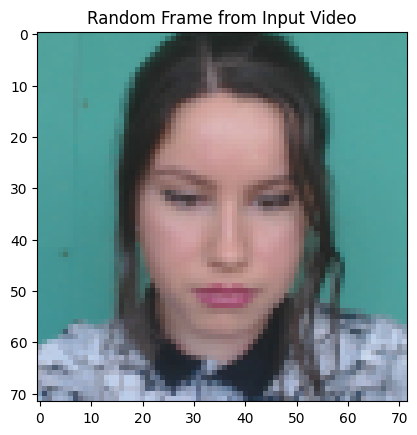

In [3]:
X = np.load('../data/preprocessed/subject1_input1.npy')
y = np.load('../data/preprocessed/subject1_label1.npy')
plt.imshow(X[115] / 255)
plt.title('Random Frame from Input Video')

Text(0.5, 1.0, 'Spatial Vector from NMF')

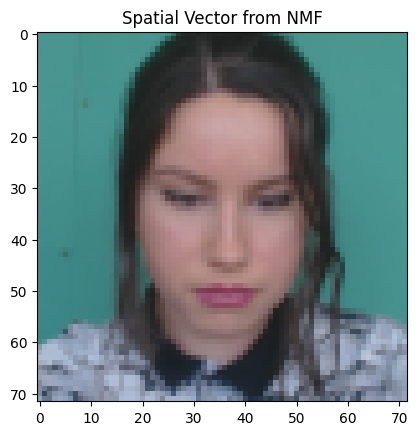

In [4]:
t, a, b, k = X.shape
V = X.reshape(t, a * b * k)
NMF_model = NMF(n_components=1, init='random', random_state=0)
W = NMF_model.fit_transform(V)
H = NMF_model.components_

frame = H.reshape(a, b, k)
plt.imshow(frame / 255 * 8)
plt.title('Spatial Vector from NMF')

Text(0.5, 0, 'Frame')

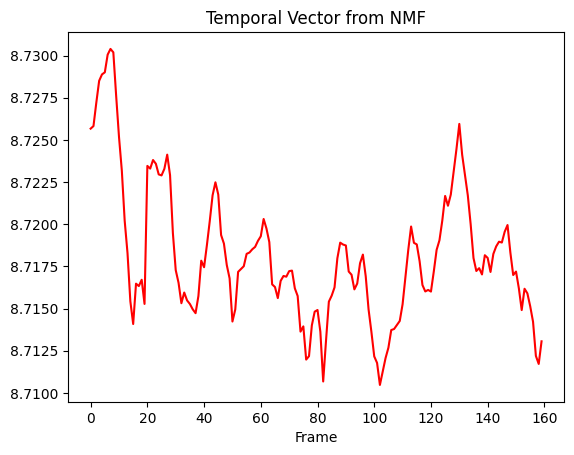

In [7]:
plt.plot(W, c='r')
plt.title('Temporal Vector from NMF')
plt.xlabel('Frame')

Text(0.5, 0, 'Frame')

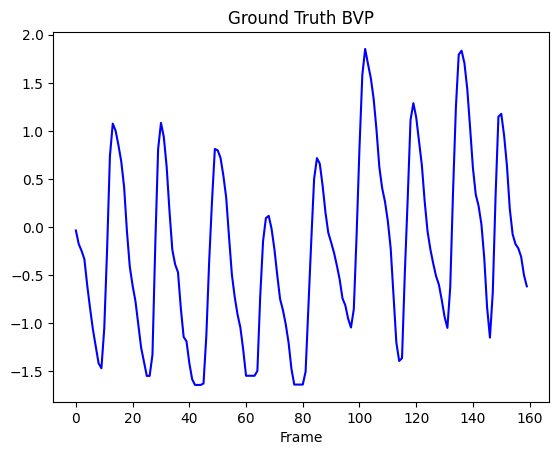

In [8]:
plt.plot(y, c='b')
plt.title('Ground Truth BVP')
plt.xlabel('Frame')

## Plotting Convolution Outputs

In [82]:
import torch, os, numpy as np
from model.FactorizePhys.FactorizePhys import FactorizePhys
from model.MyFactorizePhys.MyFactorizePhys import MyFactorizePhys
from matplotlib import pyplot as plt


MODELS = {
    'FP': FactorizePhys,
    'MFP': MyFactorizePhys
}

MODEL_PATHS = {
    'FP': 'model/FP_50.pth',
    'MFP': 'model/MFP_50.pth'
}

def load_model(model_name, *args, **kwargs):
    model = MODELS[model_name](*args, **kwargs)
    model_path = MODEL_PATHS.get(model_name)
    pretrained = model_path is not None and os.path.isfile(model_path)
    if pretrained:
        tprint(f'Loading pretrained model at {os.path.basename(model_path)}')
        state_dict = torch.load(model_path, weights_only=True)
        model.load_state_dict(state_dict)
    return model, pretrained

In [87]:
def load_input(sub, split):
    fname = f'../data/preprocessed/subject{sub}_input{split}.npy'
    X = np.load(fname)
    y = torch.tensor(np.load(fname.replace('input', 'label'))).to('cpu')
    X = np.float32(np.transpose(X, (3, 0, 1, 2)))
    X = torch.tensor(X, requires_grad=True).to('cpu')
    return X.view((1, *X.shape)), y

FP_model = load_model('FP')[0]
MFP_model = load_model('MFP')[0]
FP_model.eval();
MFP_model.eval();

In [91]:
X = load_input(1, 1)[0] # 72x72
X = torch.diff(X, dim=2)
X = MFP_model.norm(X[:, :3])
X = MFP_model.FeatureExtractor(X) # 13x13
X = MFP_model.NetworkHead.conv1(X) # 7x7
X = X - X.min() # Move to zero
images1_MFP = X.detach().clone()
images2_MFP, error = MFP_model.NetworkHead.FSAM(X)

images1_MFP = images1_MFP.numpy()
images2_MFP = images2_MFP.detach().numpy()

images1_MFP = np.mean(images1_MFP, axis=2)[0]
images2_MFP = np.mean(images2_MFP, axis=2)[0]

print(images1_MFP.shape)
print(images2_MFP.shape)

(16, 7, 7)
(16, 7, 7)


In [92]:
X = load_input(1, 1)[0] # 72x72
X = torch.diff(X, dim=2)
X = FP_model.norm(X[:, :3])
X = FP_model.rppg_feature_extractor(X) # 13x13
X = FP_model.rppg_head.conv_block(X) # 7x7
X = X - X.min() # Move to zero
images1_FP = X.detach().clone()
images2_FP, error = FP_model.rppg_head.fsam(X)

images1_FP = images1_FP.numpy()
images2_FP = images2_FP.detach().numpy()

images1_FP = np.mean(images1_FP, axis=2)[0]
images2_FP = np.mean(images2_FP, axis=2)[0]

print(images1_FP.shape)
print(images2_FP.shape)

(16, 7, 7)
(16, 7, 7)


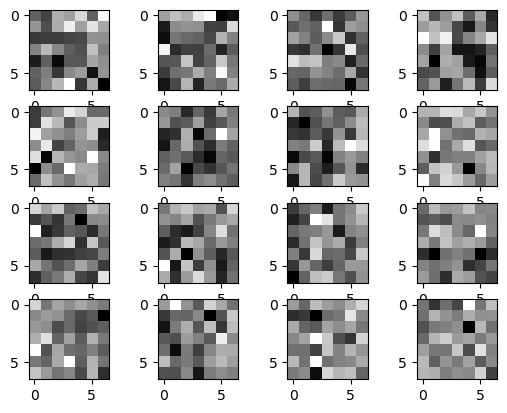

In [90]:
fig, ax2d = plt.subplots(4, 4)

for i, ax in enumerate(ax2d.flatten()):
    ax.imshow(images1_FP[i], cmap='gray')

## Plotting Predicted BVP and Ground Truth

In [110]:
X, y = load_input(1, 1)
y_pred_MFP = MFP_model(X).view(-1).detach().numpy()
y_pred_FP = FP_model(X)[0].view(-1).detach().numpy()
y = y[:len(y_pred_MFP)]

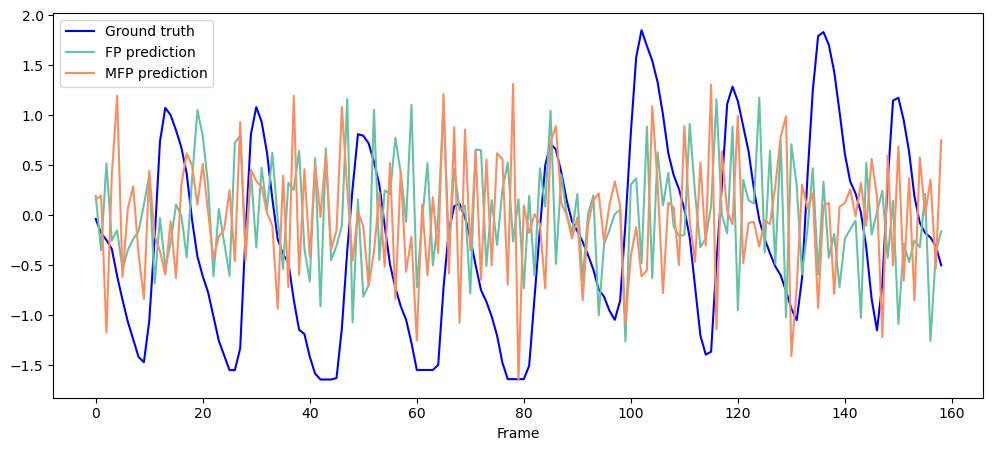

In [117]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(12, 5))
colors = mpl.colormaps['Set2'].colors

xrange = np.arange(len(y))
ax.plot(xrange, y, c='b', label='Ground truth')
ax.plot(xrange, y_pred_FP, c=colors[0], label='FP prediction')
ax.plot(xrange, y_pred_MFP, c=colors[1], label='MFP prediction')
ax.set_xlabel('Frame')
ax.legend();